In [220]:
import pandas as pd
import numpy as np
import shapefile
import time
import netCDF4 as nc
import matplotlib.pyplot as plt
from datetime import date
import matplotlib.dates as mdates
import xarray as xr
from datetime import date
import matplotlib.dates as mdates
import glob
import warnings
warnings.filterwarnings("ignore")

#### Load watersehd shapefile

In [2]:
WS_shp = 'C:/Users/zahu573/D/Watershed/Shapefile/AmericanRiver.shp'
sf = shapefile.Reader(WS_shp)
WS_name = 'American'

#### Load MODIS EVI

In [3]:
ARW_EVI_1 = xr.open_dataset('C:/Users/zahu573/D/MODIS/Data/American-NDVI-EVI-20102022-1km-MOD13A2-006_aid0001.nc')
ARW_EVI_2 = xr.open_dataset('C:/Users/zahu573/D/MODIS/Data/American-NDVI-EVI-20102022-1km-MOD13A2-006_aid0002.nc')


max_EVI = np.max([np.max(ARW_EVI_1['_1_km_16_days_EVI'][:]),np.max(ARW_EVI_2['_1_km_16_days_EVI'][:])])
min_EVI = np.min([np.min(ARW_EVI_1['_1_km_16_days_EVI'][:]),np.min(ARW_EVI_2['_1_km_16_days_EVI'][:])])

#### Load aspect

In [83]:
elv_slp_aspect = xr.open_dataset('C:/Users/zahu573/D/DEM/Surr_American_elv_slp_asp.nc')
# ws_asp = xr.open_dataset('C:/Users/zahu573/D/DEM/American_elv_slp_asp.nc')

In [5]:
# elv_slp_aspect = ws_asp.where((ws_asp['Band1']!=0)&(ws_asp['Band2']!=0)&(ws_asp['Band3']!=0))

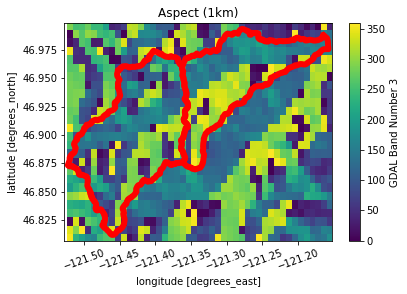

In [84]:
whole_xs=[]
whole_ys=[]
elv_slp_aspect['Band3'].plot()
for shape in sf.shapeRecords():
    # print('plot shp')        
    xs = [i[0] for i in shape.shape.points[:]]
    ys = [i[1] for i in shape.shape.points[:]]
    # xs = [ix+360 for ix in xs]
    # elif x[0][0]<0 and xs[0]>0:
    #     print('lon ranges are diffrent. subtracting 360 degree from shapefile lons')
    #     xs = [ix-360 for ix in xs]
    whole_xs.append(xs)
    whole_ys.append(ys)
    plt.plot(xs,ys,color='red',linewidth=6)
plt.xlim(np.min(np.min(whole_xs))-.005,np.max(np.max(whole_xs))+.005)
plt.ylim(np.min(np.min(whole_ys))-.005,np.max(np.max(whole_ys))+.005)
plt.title('Aspect (1km)')
plt.xticks(rotation=20)
plt.savefig('C:/Users/zahu573/D/Plots/American_Aspect_1km_.png',dpi=300)

#### Load burn severity

In [85]:
brn_sev = 'C:/Users/zahu573/D/MTBS/BS_WA/Surr_American_2017_4326.tif'
brn_sev_xr  = xr.open_dataset(brn_sev)

In [86]:
# keep 1 to 4 burn severity
brn_sev_xr_1_5 = np.where(brn_sev_xr['band_data']==6, np.nan, brn_sev_xr['band_data'])
brn_sev_xr_1_4 = np.where(brn_sev_xr_1_5==5, np.nan, brn_sev_xr_1_5)

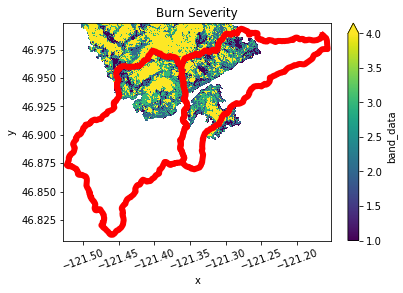

In [87]:
# plot the data
brn_sev_xr.band_data[:].plot(vmin=1,vmax=4)
for shape in sf.shapeRecords():
    # print('plot shp')        
    xs = [i[0] for i in shape.shape.points[:]]
    ys = [i[1] for i in shape.shape.points[:]]
    # xs = [ix+360 for ix in xs]
    # elif x[0][0]<0 and xs[0]>0:
    #     print('lon ranges are diffrent. subtracting 360 degree from shapefile lons')
    #     xs = [ix-360 for ix in xs]
    whole_xs.append(xs)
    whole_ys.append(ys)
    plt.plot(xs,ys,color='red',linewidth=6)
plt.xlim(np.min(np.min(whole_xs))-.005,np.max(np.max(whole_xs))+.005)
plt.ylim(np.min(np.min(whole_ys))-.005,np.max(np.max(whole_ys))+.005)
plt.title('Burn Severity')
plt.xticks(rotation=20)
plt.savefig('C:/Users/zahu573/D/Plots/BurnSev_ARW.png',dpi=300)

In [88]:
#lat and lon resolution for aspect
lat_res = np.abs(elv_slp_aspect['lat'][0].values-elv_slp_aspect['lat'][1].values)
lon_res = np.abs(elv_slp_aspect['lon'][0].values-elv_slp_aspect['lon'][1].values)
print(lat_res, lon_res)
#x and y resolution for burn severity
#x res = 0.00028807 y res = 0.00032899
print(brn_sev_xr['y'][50].values-brn_sev_xr['y'][51].values)
print(brn_sev_xr['x'][50].values-brn_sev_xr['x'][51].values)

0.007500000000000284 0.008281249999996021
0.00032899167477751234
-0.00028807300668631797


In [89]:
lon_mesh, lat_mesh = np.meshgrid(elv_slp_aspect['lon'],elv_slp_aspect['lat'])
x_mesh, y_mesh = np.meshgrid(brn_sev_xr['x'],brn_sev_xr['y'])

#### Aggregate the burn severity data to 1km by taking mean

In [90]:
bs_arr=np.empty_like(elv_slp_aspect['Band3'])
for i in range(np.shape(elv_slp_aspect['Band3'])[0]):
    for j in range(np.shape(elv_slp_aspect['Band3'])[1]):
        # print(i, j,elv_slp_aspect['Band3'][i][j].values)
        # print(lat_mesh[i][j])
        ind_x =np.where((brn_sev_xr['x'][:]>=lon_mesh[i][j]-lon_res/2)&(brn_sev_xr['x'][:]<=lon_mesh[i][j]+lon_res/2))[0]
        ind_y =np.where((brn_sev_xr['y'][:]>=lat_mesh[i][j]-lat_res/2)&(brn_sev_xr['y'][:]<=lat_mesh[i][j]+lat_res/2))[0]
        # print(lon_mesh[i][j],lat_mesh[i][j])
        # print(brn_sev_xr['x'][ind_x],brn_sev_xr['y'][ind_y])
        bs__ = np.nanmean(brn_sev_xr_1_4[0][ind_y[0]:ind_y[-1]+1,ind_x[0]:ind_x[-1]+1])
        if bs__>=1:
            print(bs__)
        try:
            bs_arr[i][j]=round(bs__)
        except:
            bs_arr[i][j]=bs__

2.6452703
3.124521
2.0853658
1.2739726
2.4380953
2.0
2.180328
2.7806604
2.6006494
1.993311
1.5820895
1.4315069
1.2916666
2.0
2.2653632
2.2014134
2.2256637
1.9295775
1.8363637
1.9605263
2.3084886
1.0714285
2.2565217
2.4452214
3.5496895
3.3253374
2.3538232
2.252818
1.7279412
2.4476988
2.1198256
2.5962732
2.8050973
2.4752624
2.2668667
2.4751554
2.2962964
2.0514705
2.7608695
2.0347552
2.850153
3.7991004
3.6770186
2.750958
2.7901862
2.0788178
2.3548386
2.090909
2.5926774
2.7808442
2.9068322
2.9385307
2.484258
2.934033
2.734472
2.659375
2.2766798
1.0
2.316794
2.6836581
3.0269866
3.3808095
2.305921
2.1711028
1.0
1.0
1.7345679
2.6873977
2.862069
2.755319
2.6710038
3.3540373
3.5682158
2.8515742
2.5630631
2.878882
2.892054
2.508361
2.357513
2.0339806
2.318376
2.76012
2.9355323
2.5249221
1.536
3.5384614
2.007949
2.573052
2.1285267
2.4905956
2.3683386
2.538961
3.7570534
3.976489
3.8871474
3.8912337
2.909091
2.6003134
2.5109718
2.150974
1.9494164
1.9584488
2.4621212
2.1784704
1.5058824
1.5686275
2.

#### create netcdf file fore new burn severity

In [110]:
fn = 'C:/Users/zahu573/D/MTBS/BS_WA/American_BurnSev_avg_1km_1_4_.nc'


In [111]:
ds = nc.Dataset(fn, 'w', format='NETCDF4')

In [112]:
#create dimension
lat = ds.createDimension('lat', len(elv_slp_aspect['lat']))
lon = ds.createDimension('lon', len(elv_slp_aspect['lon']))

In [113]:
#Add variables
lats = ds.createVariable('lat', 'f4', ('lat',))
lons = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('BurnSeverity_1km', 'f4', ('lat', 'lon',))


In [114]:
#Assign lat and lon values
lats[:] = elv_slp_aspect['lat']
lons[:] = elv_slp_aspect['lon']
#Assign NetCDF Data Values
value[:] = bs_arr

In [115]:
ds.close()

In [117]:
burn_sev_1km = xr.open_dataset(fn)
burn_sev_1km['BurnSeverity_1km']=burn_sev_1km['BurnSeverity_1km'].fillna(0)

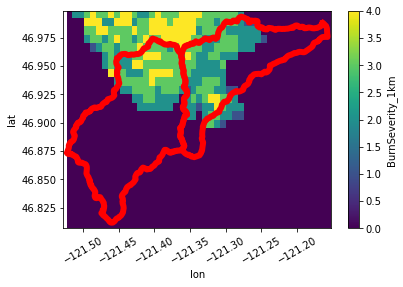

In [118]:
#plot the 1km burn severity
burn_sev_1km['BurnSeverity_1km'].plot()
for shape in sf.shapeRecords():
    # print('plot shp')        
    xs = [i[0] for i in shape.shape.points[:]]
    ys = [i[1] for i in shape.shape.points[:]]
    # xs = [ix+360 for ix in xs]
    # elif x[0][0]<0 and xs[0]>0:
    #     print('lon ranges are diffrent. subtracting 360 degree from shapefile lons')
    #     xs = [ix-360 for ix in xs]
    whole_xs.append(xs)
    whole_ys.append(ys)
    plt.plot(xs,ys,color='red',linewidth=6)
plt.xlim(np.min(np.min(whole_xs))-.005,np.max(np.max(whole_xs))+.005)
plt.ylim(np.min(np.min(whole_ys))-.005,np.max(np.max(whole_ys))+.005)
plt.xticks(rotation=30)
plt.savefig('C:/Users/zahu573/D/Plots/BurnSev_ARW_1km_1_4_.png',dpi=300)

#### Take a look at the EVI daata (optional)

(46.806956461713405, 46.99838787497345)

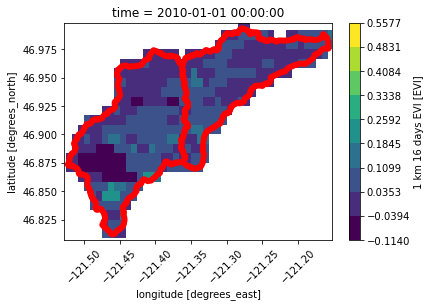

In [119]:
levels = np.linspace(min_EVI,max_EVI,10)
ARW_EVI_1['_1_km_16_days_EVI'][1].plot(levels=levels,cmap='viridis',add_colorbar=False)
ARW_EVI_2['_1_km_16_days_EVI'][1].plot(levels=levels,cmap='viridis')

whole_xs=[]
whole_ys=[]

for shape in sf.shapeRecords():
    # print('plot shp')        
    xs = [i[0] for i in shape.shape.points[:]]
    ys = [i[1] for i in shape.shape.points[:]]
    # xs = [ix+360 for ix in xs]
    # elif x[0][0]<0 and xs[0]>0:
    #     print('lon ranges are diffrent. subtracting 360 degree from shapefile lons')
    #     xs = [ix-360 for ix in xs]
    whole_xs.append(xs)
    whole_ys.append(ys)
    plt.plot(xs,ys,color='red',linewidth=6)
plt.xticks(rotation=45)
plt.xlim(np.min(np.min(whole_xs))-.005,np.max(np.max(whole_xs))+.005)
plt.ylim(np.min(np.min(whole_ys))-.005,np.max(np.max(whole_ys))+.005)

(array([-121.55, -121.5 , -121.45, -121.4 , -121.35, -121.3 , -121.25,
        -121.2 , -121.15]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

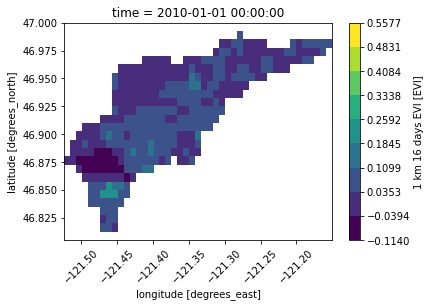

In [120]:
ARW_EVI_interp_1 = ARW_EVI_1['_1_km_16_days_EVI'][1].interp(lat=elv_slp_aspect['lat'], lon=elv_slp_aspect['lon'])
ARW_EVI_interp_2 = ARW_EVI_2['_1_km_16_days_EVI'][1].interp(lat=elv_slp_aspect['lat'], lon=elv_slp_aspect['lon'])

ARW_EVI_interp_1.plot(levels=levels,cmap='viridis',add_colorbar=False)
ARW_EVI_interp_2.plot(levels=levels,cmap='viridis')

plt.xticks(rotation=45)

### Get indices for different burn severity

In [121]:
indx_0_x, indx_0_y = np.where(burn_sev_1km['BurnSeverity_1km']==0)
indx_1_x, indx_1_y = np.where(burn_sev_1km['BurnSeverity_1km']==1)
indx_2_x, indx_2_y = np.where(burn_sev_1km['BurnSeverity_1km']==2)
indx_3_x, indx_3_y = np.where(burn_sev_1km['BurnSeverity_1km']==3)
indx_4_x, indx_4_y = np.where(burn_sev_1km['BurnSeverity_1km']==4)

### Get indices for different aspect

In [122]:
indx_n_x, indx_n_y = np.where((elv_slp_aspect['Band3'][:]>=315)|(elv_slp_aspect['Band3'][:]>=0)&(elv_slp_aspect['Band3'][:]<=45))
indx_s_x, indx_s_y = np.where((elv_slp_aspect['Band3'][:]>=135)&(elv_slp_aspect['Band3'][:]<=225))
indx_e_x, indx_e_y = np.where((elv_slp_aspect['Band3'][:]>=45)&(elv_slp_aspect['Band3'][:]<=135))
indx_w_x, indx_w_y = np.where((elv_slp_aspect['Band3'][:]>=225)&(elv_slp_aspect['Band3'][:]<=315))

### combine indices

In [123]:
indx_0=[]
indx_1=[]
indx_2=[]
indx_3=[]
indx_4=[]
indx_n=[]
indx_s=[]
indx_e=[]
indx_w=[]

In [124]:
for i,j in zip(indx_n_x,indx_n_y):
    indx_n.append((i,j))
print(len(indx_n))

for i,j in zip(indx_s_x,indx_s_y):
    indx_s.append((i,j))
print(len(indx_s))

for i,j in zip(indx_e_x,indx_e_y):
    indx_e.append((i,j))
print(len(indx_e))

for i,j in zip(indx_w_x,indx_w_y):
    indx_w.append((i,j))
print(len(indx_w))

302
253
351
273


In [125]:
for i,j in zip(indx_0_x,indx_0_y):
    indx_0.append((i,j))
print(len(indx_0))

for i,j in zip(indx_1_x,indx_1_y):
    indx_1.append((i,j))
print(len(indx_1))

for i,j in zip(indx_2_x,indx_2_y):
    indx_2.append((i,j))
print(len(indx_2))

for i,j in zip(indx_3_x,indx_3_y):
    indx_3.append((i,j))
print(len(indx_3))

for i,j in zip(indx_4_x,indx_4_y):
    indx_4.append((i,j))
print(len(indx_4))

874
11
104
124
57


In [126]:
bs_indx = [indx_0,indx_1,indx_2,indx_3,indx_4]
asp_indx = [indx_n,indx_s,indx_e,indx_w]

In [127]:
#burn sev = 1 to 4 aspect = north
n_0=[]
n_1=[]
n_2=[]
n_3=[]
n_4=[]
N_bs = [n_0,n_1,n_2,n_3,n_4]
for i in range(len(bs_indx)):
    # print(list(set(bs_indx[i]).intersection(indx_n)))
    N_bs[i]=list(set(bs_indx[i]).intersection(indx_n))
    
print(len(N_bs[0]))
print(len(N_bs[1]))
print(len(N_bs[2]))
print(len(N_bs[3]))
print(len(N_bs[4]))

228
3
15
31
25


In [128]:
#burn sev = 1 to 4 aspect = south
s_0=[]
s_1=[]
s_2=[]
s_3=[]
s_4=[]
S_bs = [s_0,s_1,s_2,s_3,s_4]
for i in range(len(bs_indx)):
    # print(list(set(bs_indx[i]).intersection(indx_s)))
    S_bs[i]=list(set(bs_indx[i]).intersection(indx_s))
    
print(len(S_bs[0]))
print(len(S_bs[1]))
print(len(S_bs[2]))
print(len(S_bs[3]))
print(len(S_bs[4]))


173
4
49
25
2


In [129]:
#burn sev = 1 to 4 aspect = east
e_0=[]
e_1=[]
e_2=[]
e_3=[]
e_4=[]
E_bs = [e_0,e_1,e_2,e_3,e_4]
for i in range(len(bs_indx)):
    # print(list(set(bs_indx[i]).intersection(indx_e)))
    E_bs[i]=list(set(bs_indx[i]).intersection(indx_e))
    
print(len(E_bs[0]))
print(len(E_bs[1]))
print(len(E_bs[2]))
print(len(E_bs[3]))
print(len(E_bs[4]))

271
2
25
42
11


In [130]:
#burn sev = 1 to 4 aspect = west
w_0=[]
w_1=[]
w_2=[]
w_3=[]
w_4=[]
W_bs = [w_0,w_1,w_2,w_3,w_4]
for i in range(len(bs_indx)):
    # print(list(set(bs_indx[i]).intersection(indx_w)))
    W_bs[i]=list(set(bs_indx[i]).intersection(indx_w))
    
print(len(W_bs[0]))
print(len(W_bs[1]))
print(len(W_bs[2]))
print(len(W_bs[3]))
print(len(W_bs[4]))

210
2
15
26
20


#### find EVI on different facing slope

In [179]:
aspects = [N_bs,S_bs,E_bs,W_bs]
aspect_names = ['North','South','East','West']
for asp_1, asp_2 in zip(aspects,aspect_names):
    print(asp_2)
    date = []
    month = []
    year = []
    ARW_mean = [[],[],[],[],[]]
    ARW_min = [[],[],[],[],[]]
    ARW_max = [[],[],[],[],[]]
    for t in range(len(ARW_EVI_1['_1_km_16_days_EVI'])):
        if ARW_EVI_1.indexes['time'].to_datetimeindex()[t].year>2009:
            date.append(str(ARW_EVI_1.indexes['time'].to_datetimeindex()[t]).split(' ')[0])
            month.append(ARW_EVI_1.indexes['time'].to_datetimeindex()[t].month)
            year.append(ARW_EVI_1.indexes['time'].to_datetimeindex()[t].year)
            # print(ARW_EVI_1.indexes['time'].to_datetimeindex()[t].month,ARW_EVI_1.indexes['time'].to_datetimeindex()[t].year)

            ARW_EVI_interp_1 = ARW_EVI_1['_1_km_16_days_EVI'][t].interp(lat=elv_slp_aspect['lat'], lon=elv_slp_aspect['lon'])
            ARW_EVI_interp_2 = ARW_EVI_2['_1_km_16_days_EVI'][t].interp(lat=elv_slp_aspect['lat'], lon=elv_slp_aspect['lon'])
            sum_ARW_1_2 = np.nansum(np.dstack((ARW_EVI_interp_1.values,ARW_EVI_interp_2.values)),2)

            #for north facing slopes seperate data for different burn severity            
            ARW_whole = [[],[],[],[],[]]
            for i in range(len(asp_1)):
                # print('Burn Sev', i+1)
                for j in range(len(asp_1[i])):
                    # print(ARW_EVI_interp_1[N_bs[i][j]].values, ARW_EVI_interp_2[N_bs[i][j]].values)
                    EVI_max_1_2 = np.nanmax([ARW_EVI_interp_1[asp_1[i][j]].values, ARW_EVI_interp_2[asp_1[i][j]].values])
                    # print(EVI_max_1_2)
                    ARW_whole[i].append(EVI_max_1_2)
                if t==10:
                    print(asp_2,i,ARW_whole[i])
                
            # for i in range(len(asp_1)):
            #     try:
            #         ARW_whole[i].append(sum_ARW_1_2[list(zip(*asp_1[i]))[0],list(zip(*asp_1[i]))[1]])
            #     except:
            #         ARW_whole[i].append(np.nan)

            for k in range(len(ARW_whole)):
                # try:
                ARW_mean[k].append(np.nanmean(ARW_whole[k]))
                ARW_min[k].append(np.nanmin(ARW_whole[k]))
                ARW_max[k].append(np.nanmax(ARW_whole[k]))
                # print(asp_2, k, len(ARW_whole[k]))
                # except:
                #     ARW_mean[k].append(np.nan)
                #     ARW_min[k].append(np.nan)
                #     ARW_max[k].append(np.nan)
                #     print(asp_2, k, 'nan')
                
    asp_df_mean = pd.DataFrame({'Date':date,'Month':month,'Year':year,'BS_0':ARW_mean[0],'BS_1':ARW_mean[1],\
                               'BS_2':ARW_mean[2],'BS_3':ARW_mean[3],'BS_4':ARW_mean[4]})
    asp_df_min = pd.DataFrame({'Date':date,'Month':month,'Year':year,'BS_0':ARW_min[0],'BS_1':ARW_min[1],\
                               'BS_2':ARW_min[2],'BS_3':ARW_min[3],'BS_4':ARW_min[4]})
    asp_df_max = pd.DataFrame({'Date':date,'Month':month,'Year':year,'BS_0':ARW_max[0],'BS_1':ARW_max[1],\
                               'BS_2':ARW_max[2],'BS_3':ARW_max[3],'BS_4':ARW_max[4]})

    # asp_df_mean.to_csv('../Aspects_bs_EVI/'+WS_name+'_'+asp_2+'_facing_1km_mean_mx.csv',index=False)
    # asp_df_min.to_csv('../Aspects_bs_EVI/'+WS_name+'_'+asp_2+'_facing_1km_min_mx.csv',index=False)
    # asp_df_max.to_csv('../Aspects_bs_EVI/'+WS_name+'_'+asp_2+'_facing_1km_max_mx.csv',index=False)

North
North 0 [nan, nan, nan, nan, 0.2442630022416573, 0.1912565853007766, nan, nan, -0.010503977287322521, nan, nan, nan, nan, nan, 0.29661400773566077, nan, nan, nan, 0.2915523516295594, nan, nan, 0.20579058394643657, nan, 0.038286270481184805, 0.023481372320255357, 0.17040424198702192, nan, 0.326105910780894, nan, 0.2948342574885784, nan, nan, nan, 0.2761427823525282, nan, 0.2982233683308459, nan, nan, 0.23923437141395962, nan, nan, nan, nan, nan, 0.16634006563081488, nan, 0.2558738136732521, 0.3004279051777966, nan, nan, 0.1551142370369329, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.044102193039870646, nan, 0.2858996300783183, nan, nan, nan, nan, nan, nan, nan, nan, 0.2890528134482772, 0.2744206786234651, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.1563928259444894, nan, 0.28934192077554, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.24489751777090935, nan, nan, nan, 0.2956971135738904, nan, nan, 0.03095480717287031, nan, nan, nan, 0.28662618214347385, nan, 0

#### Plot data from the csvs

In [211]:
filename = '../Aspects_bs_EVI/American_West_facing_1km_mean_mx.csv'
df = pd.read_csv(filename)
df_prefire = df[df['Year']<2017]
df_postfire = df[df['Year']>=2017]
df_monthly_avg_yearly = df.groupby(['Month','Year'], as_index=False).mean()

df_prefire_monthly_avg = df_prefire.groupby('Month', as_index=False).mean()
df_prefire_monthly_avg_yearly = df_prefire.groupby(['Month','Year'], as_index=False).mean()

In [212]:
from datetime import date

df_prefire_monthly_avg_yearly['Month_year']=np.nan
for d in range(len(df_prefire_monthly_avg_yearly)):
    df_prefire_monthly_avg_yearly['Month_year'][d]=date(df_prefire_monthly_avg_yearly.Year[d],df_prefire_monthly_avg_yearly.Month[d], 1)
df_prefire_monthly_avg_yearly=df_prefire_monthly_avg_yearly.sort_values(by='Month_year')

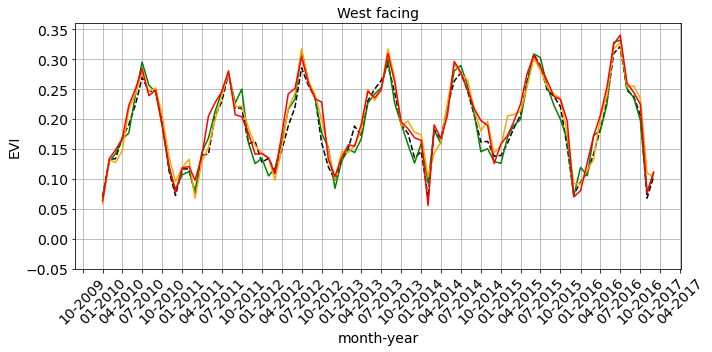

In [213]:
df_prefire_monthly_avg_yearly_indx = df_prefire_monthly_avg_yearly.set_index('Month_year')    #Setting the Date as Index
df_prefire_monthly_avg_yearly_indx.sort_index(inplace=True)

plt.figure(figsize=(10,5))
ax = df_prefire_monthly_avg_yearly_indx['BS_0'].plot(color='black',label='Burn Severity 0',linestyle='--')
ax = df_prefire_monthly_avg_yearly_indx['BS_1'].plot(color='blue',label='Burn Severity 1')
ax = df_prefire_monthly_avg_yearly_indx['BS_2'].plot(color = 'green',label='Burn Severity 2')
ax = df_prefire_monthly_avg_yearly_indx['BS_3'].plot(color='orange',label='Burn Severity 3')
ax = df_prefire_monthly_avg_yearly_indx['BS_4'].plot(color='red', label ='Burn Severity 4')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.tick_params(axis='x', rotation=45)
plt.grid('on')
plt.xlabel('month-year',fontsize=14)
plt.ylabel('EVI',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-.05,.36)
# plt.legend(fontsize=14,loc='right', bbox_to_anchor=(1.25,0.9))
plt.title(filename.split('_')[3]+' facing',fontsize=14)
plt.tight_layout()
# plt.savefig('../EVI_plots/1km/'+WS_name+'Prefire_'+filename.split('.')[0]+'.png',dpi=300)
plt.show()

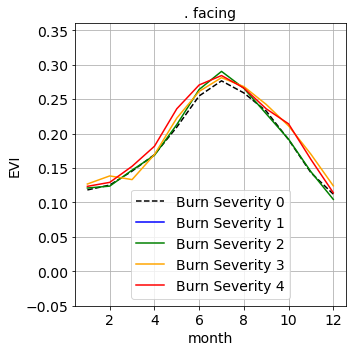

In [214]:
plt.figure(figsize=(5,5))
plt.plot(df_prefire_monthly_avg['Month'],df_prefire_monthly_avg['BS_0'],label='Burn Severity 0',color='black',linestyle='--')
plt.plot(df_prefire_monthly_avg['Month'],df_prefire_monthly_avg['BS_1'],label='Burn Severity 1',color='blue')
plt.plot(df_prefire_monthly_avg['Month'],df_prefire_monthly_avg['BS_2'],label='Burn Severity 2',color='g')
plt.plot(df_prefire_monthly_avg['Month'],df_prefire_monthly_avg['BS_3'],label='Burn Severity 3',color='orange')
plt.plot(df_prefire_monthly_avg['Month'],df_prefire_monthly_avg['BS_4'],label='Burn Severity 4',color='r')
plt.ylim(-.05,.36)
plt.xlabel('month',fontsize=14)
plt.ylabel('EVI',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid('on')
plt.title(filename.split('_')[3]+' facing',fontsize=14)
plt.tight_layout()
# plt.savefig('../EVI_plots/1km/'+WS_name+'Prefire_monthly_'+filename.split('.')[0]+'.png',dpi=300)
plt.show()

In [215]:
df_postfire_monthly_avg_yearly = df_postfire.groupby(['Month','Year'], as_index=False).mean()
df_postfire_monthly_avg_yearly['Month_year']=np.nan
for d in range(len(df_postfire_monthly_avg_yearly)):
    df_postfire_monthly_avg_yearly['Month_year'][d]=date(df_postfire_monthly_avg_yearly.Year[d], \
                                                          df_postfire_monthly_avg_yearly.Month[d], 1)
df_postfire_monthly_avg_yearly=df_postfire_monthly_avg_yearly.sort_values(by='Month_year')

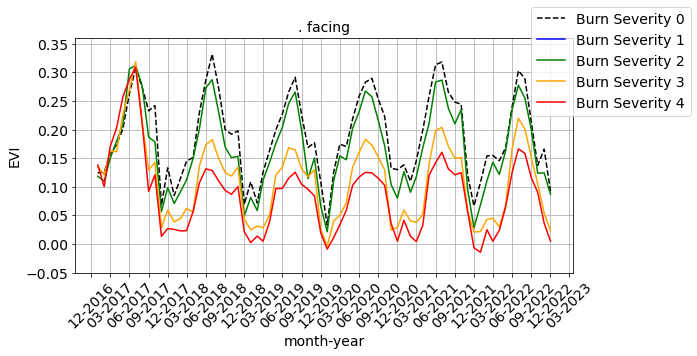

In [216]:

df_postfire_monthly_avg_yearly_indx = df_postfire_monthly_avg_yearly.set_index('Month_year')    #Setting the Date as Index
df_postfire_monthly_avg_yearly_indx.sort_index(inplace=True)

plt.figure(figsize=(10,5))
ax = df_postfire_monthly_avg_yearly_indx['BS_0'].plot(color='black',label='Burn Severity 0',linestyle='--')
ax = df_postfire_monthly_avg_yearly_indx['BS_1'].plot(color='blue',label='Burn Severity 1')
ax = df_postfire_monthly_avg_yearly_indx['BS_2'].plot(color = 'green',label='Burn Severity 2')
ax = df_postfire_monthly_avg_yearly_indx['BS_3'].plot(color='orange',label='Burn Severity 3')
ax = df_postfire_monthly_avg_yearly_indx['BS_4'].plot(color='red', label ='Burn Severity 4')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.tick_params(axis='x', rotation=45)
plt.grid('on')
plt.xlabel('month-year',fontsize=14)
plt.ylabel('EVI',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-.05,.36)
plt.legend(fontsize=14,loc='right', bbox_to_anchor=(1.25,0.9))
plt.title(filename.split('_')[3]+' facing',fontsize=14)
plt.tight_layout()
# plt.savefig('../EVI_plots/1km/'+WS_name+'Postfire_'+filename.split('.')[0]+'.png',dpi=300)
plt.show()

In [217]:
# df_prefire_monthly_avg=df_prefire_monthly_avg.reset_index()
# df_postfire_monthly_avg_yearly_indx=df_postfire_monthly_avg_yearly_indx.reset_index()
year = []
month = []
bs= [[],[],[],[],[]]
for i in range(2017, 2023):
    df_postfire_monthly_avg_yearly_post = df_postfire_monthly_avg_yearly_indx[df_postfire_monthly_avg_yearly_indx.Year==i]
    for m in range(1,13):        
        if i==2017 and m >=8:
            year.append(i)
            month.append(m)
            # df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_0']*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_0']
            bs[0].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_0'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_0'].values[0])
            bs[1].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_1'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_1'].values[0])
            bs[2].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_2'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_2'].values[0])
            bs[3].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_3'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_3'].values[0])
            bs[4].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_4'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_4'].values[0])
        elif i>2017:
            year.append(i)
            month.append(m)
            bs[0].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_0'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_0'].values[0])
            bs[1].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_1'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_1'].values[0])
            bs[2].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_2'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_2'].values[0])
            bs[3].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_3'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_3'].values[0])
            bs[4].append(df_postfire_monthly_avg_yearly_post[df_postfire_monthly_avg_yearly_post.Month==m]['BS_4'].values[0]*100/df_prefire_monthly_avg[df_prefire_monthly_avg.Month==m]['BS_4'].values[0])
    

In [218]:
df_percent_evi = pd.DataFrame({'Year':year,'Month':month,'BS_0':bs[0],'BS_1':bs[1],'BS_2':bs[2],'BS_3':bs[3],'BS_4':bs[4]})

In [219]:
df_percent_evi.to_csv('../Aspects_bs_EVI/'+WS_name+'_evi_percent_'+filename.split('_')[3]+'.csv',index=False)

In [229]:
for file in glob.glob('../Aspects_bs_EVI/'+WS_name+'_evi_percent_*csv'):
    df_percent_evi = pd.read_csv(file)
    df_percent_evi_july =df_percent_evi[df_percent_evi.Month==7]
    df_percent_evi_july=df_percent_evi_july.reset_index()
    print(df_percent_evi_july)
    df_percent_evi_july_delta = df_percent_evi_july.diff()
    print(df_percent_evi_july_delta)
    df_percent_evi_july_delta.to_csv('../Aspects_bs_EVI/'+WS_name+'_delta_evi_percent_M7_'+file.split('_')[-1].split('.')[0]+'.csv')

   index  Year  Month        BS_0  BS_1       BS_2       BS_3       BS_4
0     11  2018      7  122.599452   NaN  84.290742  60.150486  49.216972
1     23  2019      7  102.638576   NaN  75.956205  56.525592  50.339633
2     35  2020      7  102.432506   NaN  84.070861  60.951406  57.221243
3     47  2021      7  122.323256   NaN  90.736316  69.406337  65.588405
4     59  2022      7  111.918351   NaN  92.582434  76.859761  71.176649
   index  Year  Month       BS_0  BS_1      BS_2      BS_3      BS_4
0    NaN   NaN    NaN        NaN   NaN       NaN       NaN       NaN
1   12.0   1.0    0.0 -19.960876   NaN -8.334537 -3.624895  1.122661
2   12.0   1.0    0.0  -0.206071   NaN  8.114656  4.425815  6.881609
3   12.0   1.0    0.0  19.890750   NaN  6.665455  8.454931  8.367162
4   12.0   1.0    0.0 -10.404904   NaN  1.846118  7.453424  5.588244
   index  Year  Month        BS_0       BS_1       BS_2       BS_3       BS_4
0     11  2018      7  118.293609  97.506372  91.945538  73.598156  48

In [228]:
file.split('_')[-1].split('.')[0]

'West'